# Vehicle Detection and Tracking
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Implement a sliding-window technique and use a trained classifier to search for vehicles in images.
* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train the classifier.  
- These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   
- There's also a recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment the training data.  

In [1]:
import numpy as np
import cv2
import time
import glob
import pickle
from collections import deque

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from skimage.feature import hog
from scipy.ndimage.measurements import label

## Prepare the data

Number of vehicle images:     8792
Number of non vehicle images: 11498


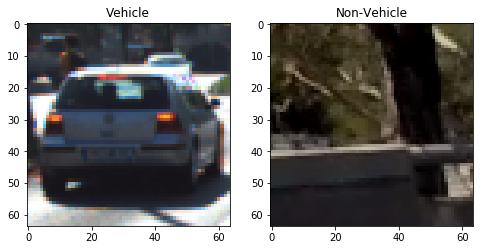

In [2]:
cars = glob.glob('../vehicles/**/*.png', recursive=True)
notcars = glob.glob('../non-vehicles/**/*.png', recursive=True)

print('Number of vehicle images:     ' + str(len(cars)))
print('Number of non vehicle images: ' + str(len(notcars)))

# prepare example images
car_image = mpimg.imread(cars[np.random.randint(0, len(cars))])
notcar_image = mpimg.imread(notcars[np.random.randint(0, len(notcars))])

# Plot the examples
fig = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Vehicle')

plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Non-Vehicle');

## HOG Features (Histogram of Oriented Gradients)
Here is a [presentation](https://www.youtube.com/watch?v=7S5qXET179I) on using Histogram of Oriented Gradient (HOG) features for pedestrian detection by Navneet Dalal, the original developer of HOG for object detection. You can see his [original paper on the subject](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf).

### scikit-image HOG
The [scikit-image](http://scikit-image.org/) package has a built in function to extract Histogram of Oriented Gradient features. A brief explanation of the algorithm and tutorial can be found here:
http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

- The scikit-image hog() function takes in a single color channel or grayscaled image as input, as well as various parameters. These parameters include orientations, pixels_per_cell and cells_per_block.

- The number of orientations is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

- The pixels_per_cell parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.

- The cells_per_block parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

- There is another optional power law or "gamma" normalization scheme set by the flag transform_sqrt. This type of normalization may help reduce the effects of shadows or other illumination variation, but will cause an error if your image contains negative values (because it's taking the square root of image values).

<img src='https://d17h27t6h515a5.cloudfront.net/topher/2016/December/585b6011_hog-visualization/hog-visualization.jpg' width=400>


Let's say you are computing HOG features for an image like the one shown above that is 64×64 pixels. If you set pixels_per_cell=(8, 8) and cells_per_block=(2, 2) and orientations=9. How many elements will you have in your HOG feature vector for the entire image?

- The HOG features for all cells in each block are computed at each block position and the block steps across and down through the image cell by cell.
- The actual number of features in your final feature vector will be the total number of block positions multiplied by the number of cells per block, times the number of orientations, or in the case shown above: 7×7×2×2×9=1764.



In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''Returns HOG features and visualization'''
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        
        return features, hog_image
    
    else: 
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        
        return features

/Users/jjl/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.04 seconds to extract HOG features...


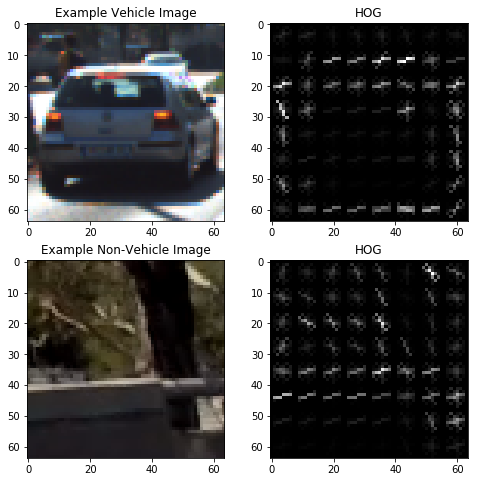

In [4]:
feat_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
feat_notcar = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)

# HOG parameters
colorspace = 'YUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0  # Can be 0, 1, 2, or "ALL"

t=time.time()

_, hog_car = get_hog_features(car_image[:, :, 0], orient, pix_per_cell, cell_per_block, 
                              vis=True, feature_vec=False)
_, hog_notcar = get_hog_features(notcar_image[:, :, 0], orient, pix_per_cell, cell_per_block, 
                                 vis=True, feature_vec=False)

t2 = time.time()
print(round(t2-t, 2), 'seconds to extract HOG features...')

# Plot the examples
fig = plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(car_image, cmap='gray')
plt.title('Example Vehicle Image')

plt.subplot(222)
plt.imshow(hog_car, cmap='gray')
plt.title('HOG')

plt.subplot(223)
plt.imshow(notcar_image, cmap='gray')
plt.title('Example Non-Vehicle Image')

plt.subplot(224)
plt.imshow(hog_notcar, cmap='gray')
plt.title('HOG');


## Spatial Binning of Color
<img src='https://d17h27t6h515a5.cloudfront.net/topher/2016/December/585c6ac5_spatial-binning/spatial-binning.jpg' width=400>

Raw pixel values are still quite useful to include in your feature vector in searching for cars.

As you can see in the example above, even going all the way down to 32 x 32 pixel resolution, the car itself is still clearly identifiable by eye, and this means that the relevant features are still preserved at this resolution.



In [5]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 

    return features

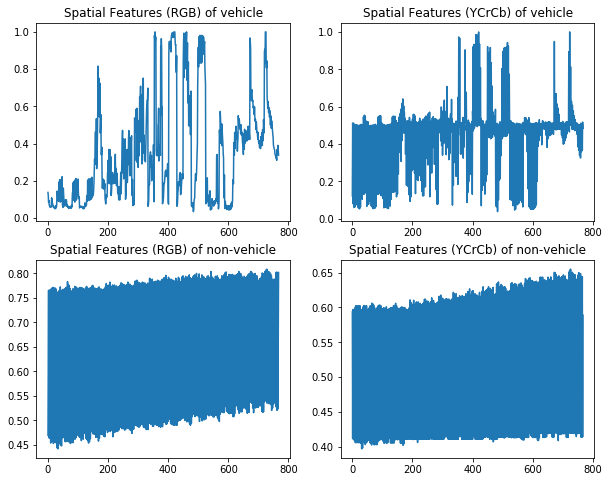

In [6]:
car_spatial_rgb = bin_spatial(car_image, color_space='RGB', size=(16,16))
car_spatial_ycrcb = bin_spatial(car_image, color_space='YCrCb', size=(16,16))

notcar_spatial__rgb = bin_spatial(notcar_image, color_space='RGB', size=(16,16))
notcar_spatial_ycrcb = bin_spatial(notcar_image, color_space='YCrCb', size=(16,16))

# Plot features
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(car_spatial_rgb)
plt.title('Spatial Features (RGB) of vehicle')

plt.subplot(222)
plt.plot(car_spatial_ycrcb)
plt.title('Spatial Features (YCrCb) of vehicle')

plt.subplot(223)
plt.plot(notcar_spatial__rgb)
plt.title('Spatial Features (RGB) of non-vehicle')

plt.subplot(224)
plt.plot(notcar_spatial_ycrcb)
plt.title('Spatial Features (YCrCb) of non-vehicle');

## Histograms of Color
Now we'll look at histograms of pixel intensity (color histograms) as features.

In [6]:
# function to compute color histogram features  
def color_hist(img, nbins=16, bins_range=(0, 256)):
    
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    return rhist, ghist, bhist, bin_centers, hist_features

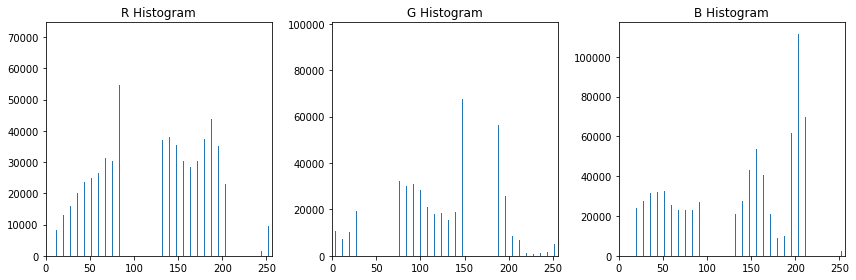

In [8]:
# Read in the image
image = mpimg.imread('./test_images/test1.jpg')

rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.bar(bincen, rh[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bincen, gh[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bincen, bh[0])
plt.xlim(0, 256)
plt.title('B Histogram')
plt.tight_layout()

## Explore Color Spaces
You can study the distribution of color values in an image by plotting each pixel in some color space. Here's a code snippet that you can use to generate 3D plots:



In [9]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(4,4))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=10, pad=6)
    ax.set_xlabel(axis_labels[0], fontsize=12, labelpad=12)
    ax.set_ylabel(axis_labels[1], fontsize=12, labelpad=12)
    ax.set_zlabel(axis_labels[2], fontsize=12, labelpad=12)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

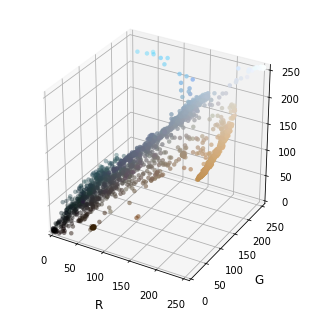

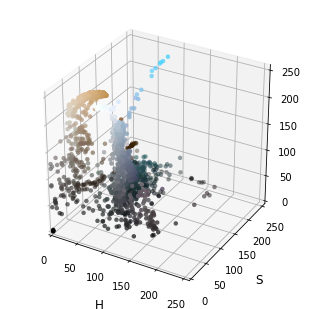

In [10]:
# Select a small fraction of pixels to plot by subsampling it
img = np.copy(image)
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

## Combine Features and Normalize
Now that you've got several feature extraction methods in your toolkit, you're almost ready to train a classifier, but first, as in any machine learning application, you need to normalize your data. 

In [7]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    return features


def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features


def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), 
                     hist_bins=32, hist_range=(0, 256)):
    '''Extract features from a list of images'''
    # Create a list to append feature vectors to
    features = []
    
    for file in imgs:
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
        else:
            feature_image = np.copy(image)   
            
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() to get color histogram features
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
        
    # Return list of feature vectors
    return features


In [8]:
cars = [cars[i] for i in np.random.randint(len(cars), size=len(cars))]
notcars = [notcars[i] for i in np.random.randint(len(notcars), size=len(notcars))]

start = time.time()
print('Starting up...')
car_features = extract_features(cars, cspace='YCrCb', spatial_size=(16,16),
                        hist_bins=16, hist_range=(0, 256))
print('Time elapsed (cars): {:.2f} sec'.format(time.time()-start))

start = time.time()
notcar_features = extract_features(notcars, cspace='YCrCb', spatial_size=(16, 16),
                        hist_bins=16, hist_range=(0, 256))
print('Time elapsed (notcars): {:.2f} sec'.format(time.time()-start))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print('Feature length:', scaled_X.shape[1])

Starting up...
Time elapsed (cars): 15.07 sec
Time elapsed (notcars): 20.79 sec
Feature length: 816


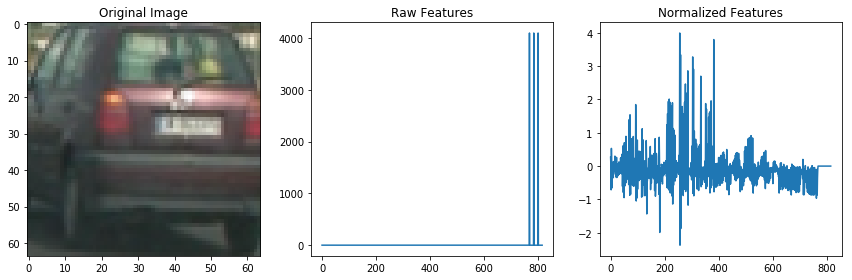

In [13]:
# Plot an example of raw and scaled features
car_ind = np.random.randint(0, len(cars))
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')

plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')

plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
plt.tight_layout()

## Sliding Windows
It will be useful to have a function to perform a sliding window search on an image.

- The function takes in an image, start and stop positions in both x and y (imagine a bounding box for the entire search region), window size (x and y dimensions), and overlap fraction (also for both x and y). 
- The function returns a list of bounding boxes for the search windows, which will then be passed to draw draw_boxes() function.

<img src='https://d17h27t6h515a5.cloudfront.net/topher/2016/December/585d9293_sliding-window/sliding-window.jpg' width=300>

In [9]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy
    
    
# function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched 
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Cmpute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        
        for xs in range(nx_windows):
            
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

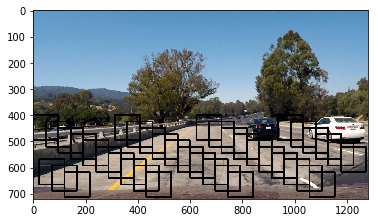

In [16]:
# specify different window sizes and overlap
window_overlap = (0.5, 0.6)
window_size  = (96, 64)
y_pct = (.7, .8)

window_size  = (196, 144)
y_pct = (.7, 1.0)

# specify the search window
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                       xy_window=(96,96), xy_overlap=(0.75, 0.75))
# plot only a few of the windows
subwindows = [windows[i] for i in range(len(windows)) if i%13==0]

window_img = draw_boxes(image, subwindows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img);

## Extracting Features in Single Images

In [10]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [11]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='YUV', spatial_size=(16, 16),
                        hist_bins=32, orient=11, 
                        pix_per_cell=16, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=False, hog_feat=True):    
    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            
    else: feature_image = np.copy(img)   
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        #6) Append features to list
        img_features.append(hist_features)
        
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        
        if hog_channel == 'ALL':
            
            hog_features = []
            
            for channel in range(feature_image.shape[2]):
                
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        #8) Append features to list
        img_features.append(np.array(hog_features))

    #9) Return concatenated array of features

    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YUV', 
                    spatial_size=(16, 16), hist_bins=32, 
                    hist_range=(0, 256), orient=11, 
                    pix_per_cell=16, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=False, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows

In [12]:
### Tune these parameters
color_space = 'YUV'     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11             # HOG orientations
pix_per_cell = 16       # HOG pixels per cell
cell_per_block = 2      # HOG cells per block
hog_channel = 'ALL'     # 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16          # Number of histogram bins
spatial_feat = True     # Spatial features on or off
hist_feat = False       # Histogram features on or off
hog_feat = True         # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

start = time.time()
print('Starting cars...')
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Time elapsed (cars): {:.2f} sec'.format(time.time()-start))

start = time.time()
print('Starting notcars...')
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Time elapsed (notcars): {:.2f} sec'.format(time.time()-start))

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
#rand = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, stratify=y, test_size=0.2, random_state=42)

print('Feature vector length:', X_train.shape[1])

Starting cars...


/Users/jjl/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Time elapsed (cars): 35.32 sec
Starting notcars...
Time elapsed (notcars): 47.66 sec
Feature vector length: 1956


## Train Classifiers (SVM, MLP)


In [13]:
# Use a linear SVC 
svc = LinearSVC(C=.001)

# Check the training time
t=time.time()
print('Starting...')
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Starting...
2.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9933


In [20]:
# Use a neural net
mlp = MLPClassifier()

# Check the training time
t=time.time()
print('Starting...')
mlp.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train MLP...')

# Check the score
print('Test Accuracy of MLP = ', round(mlp.score(X_test, y_test), 4))

Starting...
12.2 Seconds to train MLP...
Test Accuracy of MLP =  0.9978


## Look at test images
Let's use the SVM first...

Starting...


/Users/jjl/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


10.79 Seconds to search


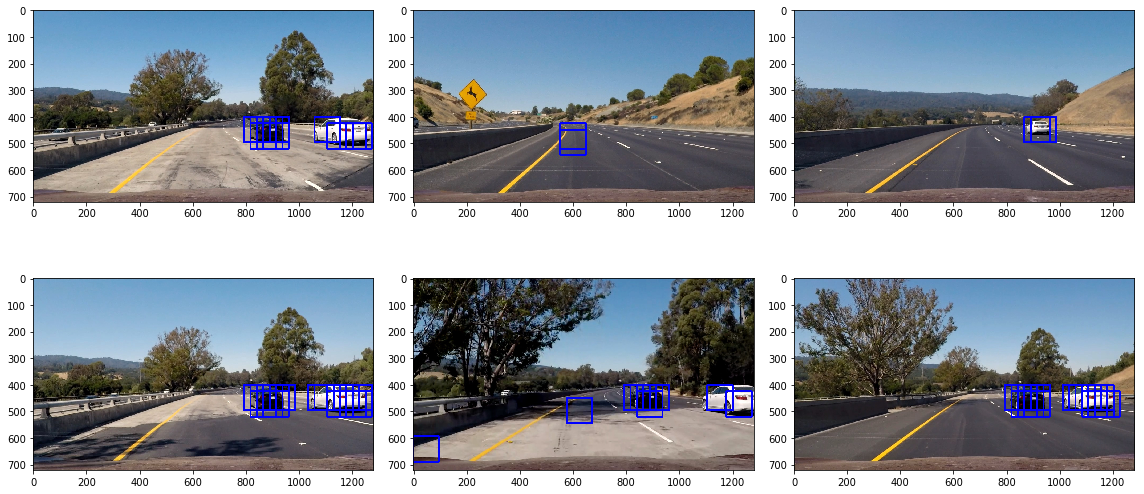

In [17]:
images = glob.glob('./test_images/*.jpg')
plt.figure(figsize=(16,8))

t=time.time()
print('Starting...')
for i, file in enumerate(images):

    image = mpimg.imread(file)
    draw_image = np.copy(image)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    plt.subplot(2,3,i+1)
    plt.imshow(window_img)

print(round(time.time()-t, 2), 'Seconds to search')
plt.tight_layout()

Now let's try the MLP...

Starting...


/Users/jjl/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


12.66 Seconds to search


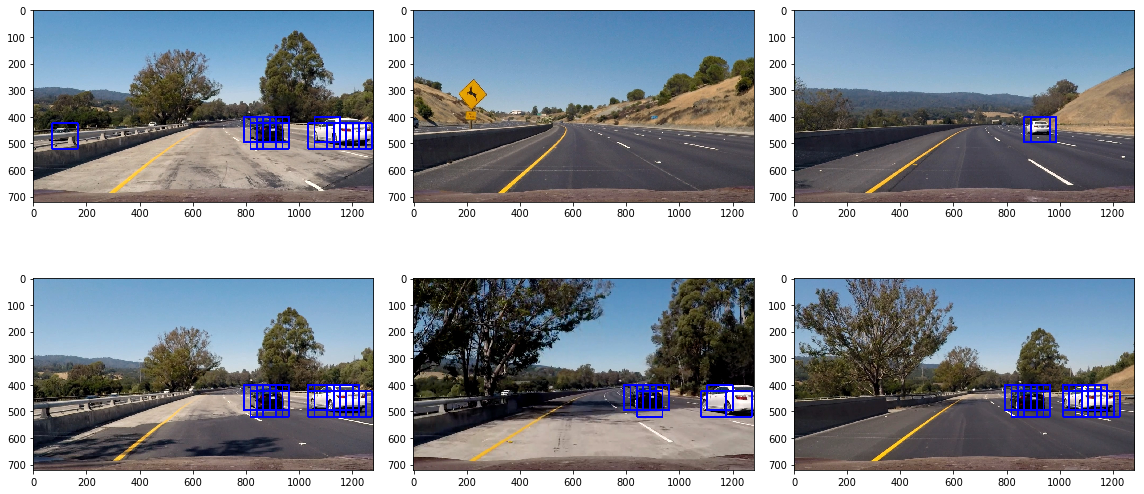

In [22]:
images = glob.glob('./test_images/*.jpg')
plt.figure(figsize=(16,8))

t=time.time()
print('Starting...')
for i, file in enumerate(images):

    image = mpimg.imread(file)
    draw_image = np.copy(image)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    hot_windows = search_windows(image, windows, mlp, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    plt.subplot(2,3,i+1)
    plt.imshow(window_img)

print(round(time.time()-t, 2), 'Seconds to search')
plt.tight_layout()

## Look at SVM decision function


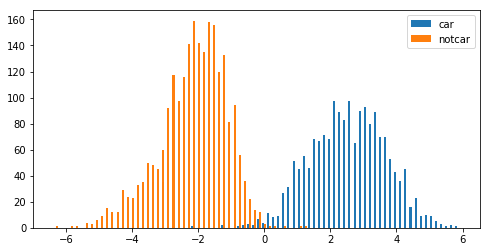

In [55]:
svc_margins = svc.decision_function(X_test)

plt.figure(figsize=(8,4))
plt.hist((svc_margins[y_test==1], svc_margins[y_test==0]), bins=80, label=('car', 'notcar'));
plt.legend();


## Feature Importances
By fitting a decision tree based model, we can also look for "important features" within the training data.

Starting...
34.94 Seconds to train AdaBoost...


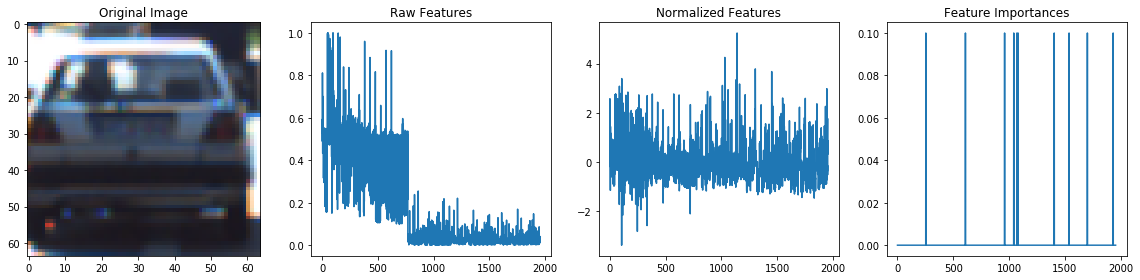

In [79]:
from sklearn.ensemble import AdaBoostClassifier

# Fit a decision-tree based model
clf = AdaBoostClassifier(n_estimators=10)
t=time.time()
print('Starting...')
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train AdaBoost...')

# Plot raw & scaled features, feature importances
car_ind = np.random.randint(0, len(cars))
plt.figure(figsize=(16,4))

plt.subplot(141)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')

plt.subplot(142)
plt.plot(X[car_ind])
plt.title('Raw Features')

plt.subplot(143)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')

plt.subplot(144)
plt.plot(clf.feature_importances_)
plt.title('Feature Importances')
plt.tight_layout()

## HOG Sub-Sampling

The `find_cars` function only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. 
- Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. 
- This means that a cells_per_step = 2 would result in a search window overlap of 75%. 
- Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

<img src='https://d17h27t6h515a5.cloudfront.net/topher/2017/February/58a8b3a1_hog-sub/hog-sub.jpg' width=300>

In [57]:
def convert_color(img, conv='RGB2YUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [70]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, clf, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    '''Take image input and return list of box detections'''
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    
    # Instead of overlap, define how many cells to step
    #cells_per_step = int((1-overlap)*window / pix_per_cell)  # value equals 2 for 8x8 pix_per_cell
    cells_per_step = 1
    
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    
    for xb in range(nxsteps):
        
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)  # un-comment to add color histogram

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))  
            
            # Un-comment to use simple binary predictions
            #test_prediction = clf.predict(test_features)
            #if test_prediction == 1:
            
            if clf.decision_function(test_features) > 0.5:
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                box_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                
    return box_list


Starting...


/Users/jjl/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.84 Seconds to search 6 images.


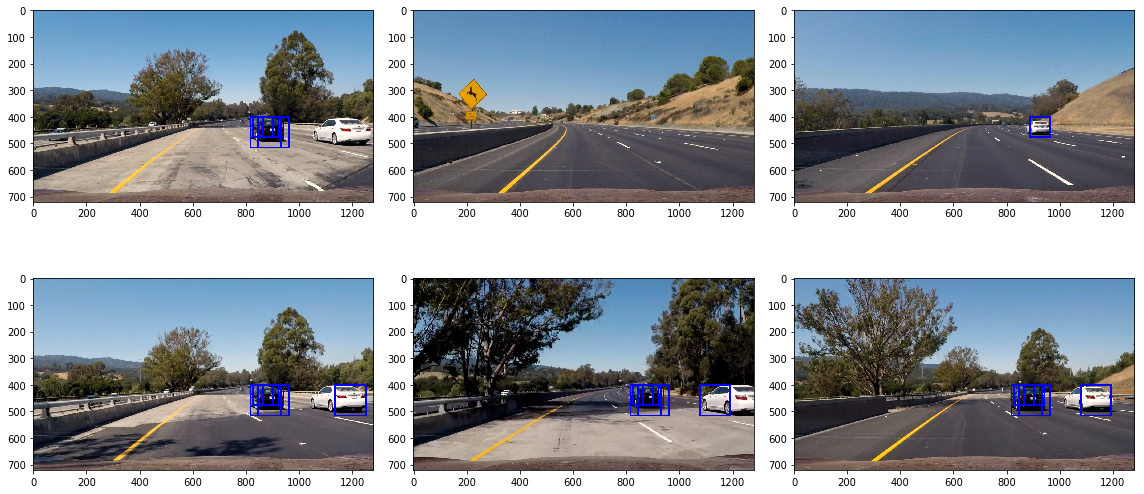

In [67]:
# Find cars in test images   
params = [(400, 700, 500, 1280, 1.8),  # ystart, ystop, xstart, xstop, scale
          (400, 500, 500, 1280, 1.2)
         ]
    
images = glob.glob('./test_images/*.jpg')
plt.figure(figsize=(16,8))

t = time.time()
print('Starting...')
for i, file in enumerate(images):
    
    image = mpimg.imread(file)
    box_list = []
    draw_image = image.copy()
    
    for ystart, ystop, xstart, xstop, scale in params:
        
        box_current = find_cars(image, ystart, ystop, xstart, xstop, scale,
                                svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                                spatial_size, hist_bins)
        box_list.extend(box_current)
        
    for box in box_list:
        
        cv2.rectangle(draw_image, box[0], box[1], (0, 0, 255), 6)

    plt.subplot(2,3,i+1)
    plt.imshow(draw_image)
    
print(round(time.time()-t, 2), 'Seconds to search', len(images), 'images.')
plt.tight_layout()


## Heatmap Thresholding
You can see that overlapping detections exist for each of the two vehicles, and in two of the frames, I find a false positive detection on the guardrail to the left. In this exercise, you'll build a heat-map from these detections in order to combine overlapping detections and remove false positives.
<img src='https://d17h27t6h515a5.cloudfront.net/topher/2017/January/588e7242_screen-shot-2017-01-29-at-2.52.00-pm/screen-shot-2017-01-29-at-2.52.00-pm.png' width=300>


To make a heat-map, you're simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by your classifier. The individual heat-maps for the above images look like this:
<img src='https://d17h27t6h515a5.cloudfront.net/topher/2017/January/588eaef6_screen-shot-2017-01-29-at-7.11.18-pm/screen-shot-2017-01-29-at-7.11.18-pm.png' width=300>


There are many ways you could go about trying to figure out how many cars you have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the label() function from scipy.ndimage.measurements. 

Now labels is a 2-tuple, where the first item is an array the size of the heatmap input image and the second element is the number of labels (cars) found.

In the above series of images the same false positive window appeared twice, so if I set a threshold of 2 (meaning set all values <= 2 to 0) and then run the labels() function. I get a result that 2 cars were identified (the two islands in the heat-map) and the labeled image where pixels are set to 0 for background, 1 for car number 1, and 2 for car number 2.

<img src='https://d17h27t6h515a5.cloudfront.net/topher/2017/January/588e95cb_screen-shot-2017-01-29-at-5.23.31-pm/screen-shot-2017-01-29-at-5.23.31-pm.png' width=300>

In [59]:
def add_heat(heatmap, bbox_list):
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, color=(0,0,255)):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, 6)
        cv2.putText(img,"Vehicle: " + "{:0.0f}".format(car_number), 
                    org=(bbox[0][0],bbox[0][1]-20), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, 
                    color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
        
    # Return the image
    return img


Starting...


/Users/jjl/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2.49 Seconds to search 6 images.


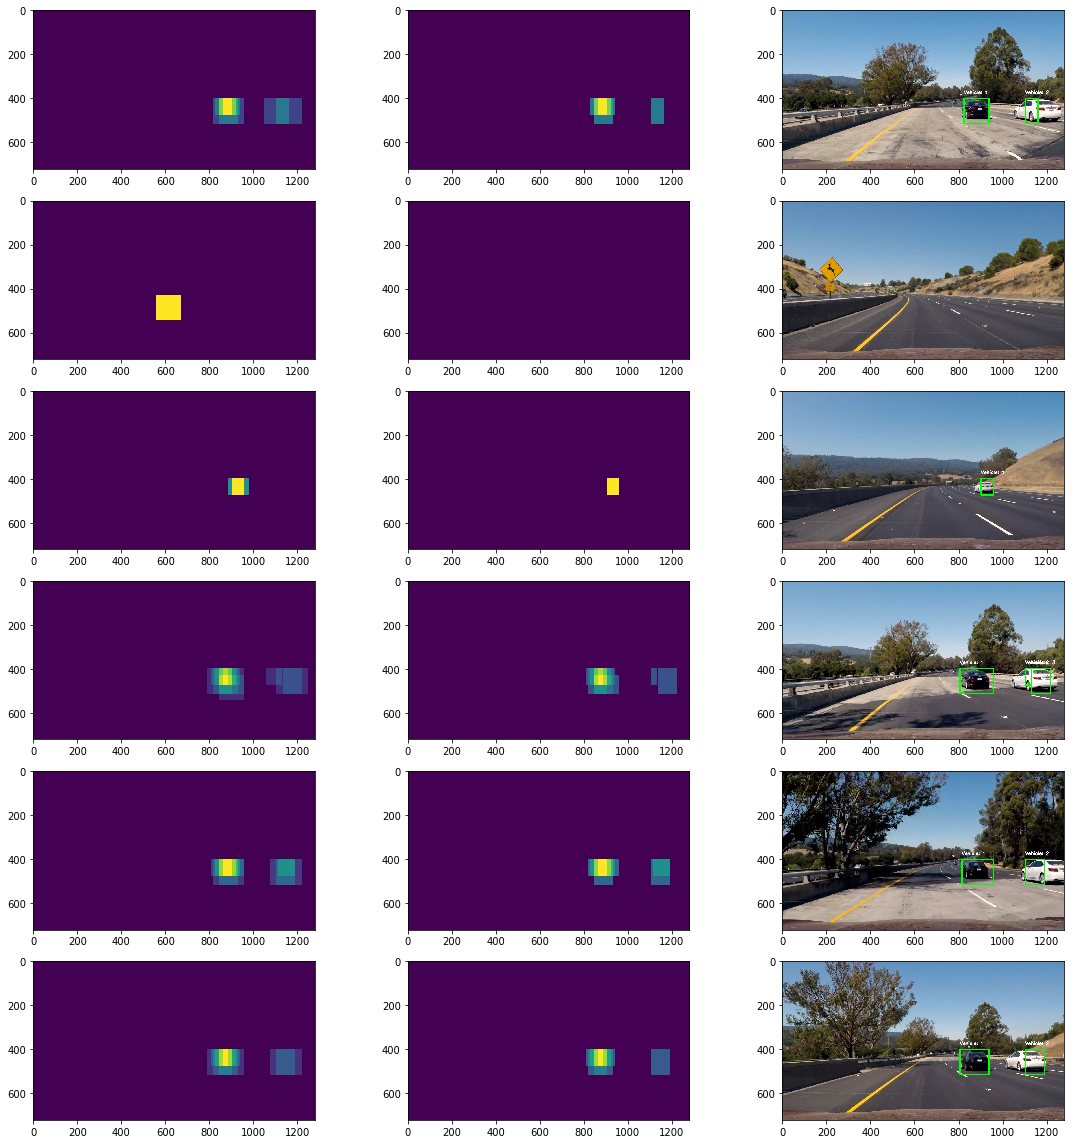

In [71]:
# Look at test images
images = glob.glob('./test_images/*.jpg')
plt.figure(figsize=(16,16))

t = time.time()
print('Starting...')
for i, file in enumerate(images):
    image = mpimg.imread(file)
    box_list = []
    for ystart, ystop, xstart, xstop, scale in params:
        box_current = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, X_scaler, 
                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list.extend(box_current)
        
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    
    plt.subplot(6,3,i*3+1)
    plt.imshow(heat)    

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    plt.subplot(6,3,i*3+2)
    plt.imshow(heatmap)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(image.copy(), labels, color=(0, 255, 0))

    plt.subplot(6,3,i*3+3)
    plt.imshow(draw_image)
    
print(round(time.time()-t, 2), 'Seconds to search', len(images), 'images.')
plt.tight_layout()

## Process video output
Download videos from here: https://github.com/udacity/CarND-Advanced-Lane-Lines

In [129]:
def process_image(image):
    
    box_list = []
    
    for ystart, ystop, xstart, xstop, scale in params:
        
        box_current = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, X_scaler, 
                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list.extend(box_current)
    
    global_box_list.append(box_list)
    
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for bboxes in global_box_list:
        heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    heatmap = np.clip(heat, 0, 255)
    
    # Un-comment to display the heatmaps
    #draw_image = draw_boxes(np.copy(image), box_list, color=(0,0,255), thick=4)

    # Draw bounding boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(np.copy(image), labels, color=(0,255,0))
    
    ### Add subwindows to output ###
    # Display the box detections
    box_img = draw_boxes(np.copy(image), box_list, color=(0,0,255), thick=4)
    draw_image[20:200, 600:920] = cv2.resize(box_img, (320,180), interpolation=cv2.INTER_AREA)

    # Display the heatmap
    heat_img = np.dstack((heatmap, heatmap, heatmap))
    draw_image[20:200, 940:1260] = cv2.resize(heat_img, (320,180), interpolation=cv2.INTER_AREA)*255
    ################################

    return draw_image 

In [130]:
# ystart, ystop, xstart, xstop, scale
params = [(400, 700, 500, 1280, 1.8), 
          (400, 500, 500, 1280, 1.2)
         ]

buffer_size = 11
heat_threshold = 7

global_box_list = deque(maxlen = buffer_size)

In [131]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'output_video_test.mp4'
input_video = '../videos/project_video.mp4'
clip = VideoFileClip(input_video).subclip(25,29)

video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video_test1.mp4
[MoviePy] Writing video output_video_test1.mp4


 99%|█████████▉| 100/101 [00:20<00:00,  5.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_test1.mp4 

CPU times: user 15.2 s, sys: 3.72 s, total: 18.9 s
Wall time: 21.5 s


---


# Advanced Lane Finding

The steps are:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [29]:
import numpy as np
import cv2
import glob
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import pickle

In [30]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0,255), convert_gray=False):
    '''Takes an image, gradient orientation, and threshold min/max values.'''
    # Convert to grayscale
    if convert_gray:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()

    # Apply x or y gradient with the OpenCV Sobel() function, take the absolute value
    if orient == 'x':
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


In [31]:
# work on defining perspective transformation area
image = mpimg.imread('./test_images/test1.jpg')
img_size = (image.shape[1], image.shape[0])

bot_width = .62  # pct of bottom trapezoid height
mid_width = .08  # pct of middle "         "
height_pct = .63  # pct for trapezoid height
bottom_trim = .935  # pct from top to bottom, avoid car hood

src = np.float32([
        [img_size[0]*(.5-mid_width/2), img_size[1]*height_pct],  # top left
        [img_size[0]*(.5+mid_width/2), img_size[1]*height_pct],  # top right
        [img_size[0]*(.5+bot_width/2), img_size[1]*bottom_trim], # bottom right
        [img_size[0]*(.5-bot_width/2.15), img_size[1]*bottom_trim]  # bottom left
    ])

# destination warped image
offset = img_size[0]*.25
dst = np.float32([
        [offset, 0],                            # top left
        [(img_size[0] - offset), 0],            # top right
        [(img_size[0] - offset), img_size[1]],  # bottom right
        [offset, img_size[1]],                  # bottom left
    ])

# transorm
M = cv2.getPerspectiveTransform(src, dst)

# inverse transform
Minv = cv2.getPerspectiveTransform(dst, src)

In [32]:
def find_window_centroids(warped, window_width, window_height, margin):
    '''Run the sliding window search'''
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [33]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.detected = False     # was the line detected in the last iteration?
        self.recent_xfitted = []  # x values of the last n fits of the line
        self.bestx = None         # average x values of the fitted line over the last n iterations
        self.best_fit = None      # polynomial coefficients averaged over the last n iterations
        self.current_fit = [np.array([False])]  # polynomial coefficients for the most recent fit
        self.radius_of_curvature = None  # radius of curvature of the line in some units
        self.deg_per_meter = None        # degrees of curvature per meter (or other units, pixels etc.)
        self.line_base_pos = None        # distance in meters of vehicle center from the line
        self.diffs = np.array([0,0,0], dtype='float')  # diff in fit coefficients between last & new fits
        self.allx = None  # x values for detected line pixels
        self.ally = None  # y values for detected line pixels


# Define a class to track the lane lines
class Tracker():
    def __init__(self, smoothing=11):
        self.recent_centers = deque(maxlen=smoothing)  # store the past center values to smooth the output
        self.window_width = 50 
        self.window_height = 80  # Break image into 9 vertical layers since image height is 720
        self.margin = 25  # How much to slide left and right for searching
        self.ym_per_pix = 30/720   # meters per pixel in vertical axis
        self.xm_per_pix = 3.7/700  # meters per pixel in horizontal axis
        self.smooth_factor = 15  # how many frames to look back for smoothing
        
    def find_window_centroids(self, warped):
        '''Run the sliding window search'''
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin
        
        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
        
        self.recent_centers.append(window_centroids)
        
        #return window_centroids  # return just the current centroids

        return np.average(self.recent_centers, axis=0)  # smooth the markers

In [34]:
def gen_binary(image, s_thresh=(100,255), v_thresh = (100,255), sx_thresh=(12,255)):
    '''Combine Gradient and Color Threshold'''
    img = np.copy(image)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    
    # Sobel x
    sxbinary = abs_sobel_thresh(v_channel, orient='x', thresh=sx_thresh, convert_gray=False)

    # Sobel y, keep static threshold
    sybinary = abs_sobel_thresh(v_channel, orient='y', thresh=(25,255), convert_gray=False)

    # Threshold gradient
    grad_binary = np.zeros_like(s_channel)
    grad_binary[(sxbinary == 1) & (sybinary ==1)] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1

    c_binary = np.zeros_like(s_channel)
    c_binary[(s_binary == 1) & (v_binary ==1)] = 1
    
    result = np.zeros_like(sxbinary)
    result[(grad_binary == 1) | (c_binary == 1)] = 1

    return result
    

In [35]:
def process_lanes(image):
    '''Pipeline to annotate images with lane lines'''
    window_height = curve_centers.window_height
    window_width = curve_centers.window_width
    
    img = cv2.undistort(image, mtx, dist, None, mtx)

    # 1. perspective transform, 2. generate binary pixel of interests
    #preprocessImage = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    #warped = gen_binary(preprocessImage)
    
    # 1. generate binary pixel of interests, 2. perspective transform
    preprocessImage = gen_binary(img)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)

    # search the sliding windows
    window_centroids = curve_centers.find_window_centroids(warped)

    # Points to find left and right lane lines
    leftx = []
    rightx = []

    # Go through each level of detected windows
    for level in range(0,len(window_centroids)):
        # add center value found in frame to list of lane points
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        
    # Fit the lane boundaries to the left & right center positions found
    yvals = range(0, warped.shape[0])  # use for extrapolating line in continuous space

    # Use box centers' y-values
    res_yvals = np.arange(warped.shape[0]-(window_height/2), 0, -window_height)

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]  # create continuous values
    left_fitx = np.array(left_fitx, np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis=0), 
                                  np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)    
    right_lane = np.array(list(zip(np.concatenate((right_fitx - window_width/2, right_fitx[::-1] + window_width/2), axis=0), 
                                   np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
    middle_marker = np.array(list(zip(np.concatenate((left_fitx + window_width/2, right_fitx[::-1] - window_width/2), axis=0), 
                                      np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)

    cv2.fillPoly(road, [left_lane], (0,0,255))  # draw left blue
    cv2.fillPoly(road, [right_lane], (255,0,0))  # draw right red
    cv2.fillPoly(road, [middle_marker], (100,100,0))  # draw middle of lane
    cv2.fillPoly(road_bkg, [left_lane], (255,255,255))
    cv2.fillPoly(road_bkg, [right_lane], (255,255,255))    
    
    # warp lane lines back to original image
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)

    # plot lane lines w/  undistorted image
    base = cv2.addWeighted(img, 1, road_warped_bkg, -1.0, 0)
    result = cv2.addWeighted(base, 1, road_warped, 1.0, 0)
    
    # calculate the radius of curvature
    ym_per_pix = curve_centers.ym_per_pix
    xm_per_pix = curve_centers.xm_per_pix

    # Fit new polynomials to x,y in world space
    curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx, np.float32)*xm_per_pix, 2)
    right_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(rightx, np.float32)*xm_per_pix, 2)

    # Calculate the new radii of curvature
    curverad = ((1 + (2*curve_fit_cr[0] * yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/np.abs(2*curve_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0] * yvals[-1]*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])

    # calculate offset of car on road
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center - warped.shape[1]/2) * xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # draw text: curvature, offset, speed(?)
    cv2.putText(result, 'Radius of Curvature (L) = ' + str(round(curverad,1)) + '(m)', (50,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Radius of Curvature (R) = ' + str(round(right_curverad,1)) + '(m)', (50,100), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result,'Vehicle is ' + str(abs(round(center_diff,3))) + 'm ' + side_pos + ' of center', (50,150), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return result

## Process the video (Lane Lines + Vehicle Detection)

In [36]:
def pipeline(image):
    lane_image = process_lanes(image)  # lane finding
    
    box_list = []
    
    for ystart, ystop, xstart, xstop, scale in params:
        
        box_current = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, X_scaler, 
                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list.extend(box_current)
    
        
    global_box_list.append(box_list)
    
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for bboxes in global_box_list:
        heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    heatmap = np.clip(heat, 0, 255)

    # Draw bounding boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(lane_image, labels, color=(0, 255, 0))

    return draw_image 

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera_cal_dist.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

output_video = 'lane_plus_vehicle_video.mp4'
input_video = '../videos/project_video.mp4'

clip = VideoFileClip(input_video)#.subclip(25,28)
curve_centers = Tracker()
video_clip = clip.fl_image(pipeline)
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video lane_plus_vehicle_video.mp4
[MoviePy] Writing video lane_plus_vehicle_video.mp4


100%|█████████▉| 1260/1261 [09:13<00:00,  2.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lane_plus_vehicle_video.mp4 

CPU times: user 8min 16s, sys: 1min 57s, total: 10min 14s
Wall time: 9min 15s


### Only process every `x` frames

In [ ]:
clip = VideoFileClip(input_video)
fps = clip.fps
num_frames = int(clip.fps * clip.duration)
img_list = []

t=time.time()
for i in range(0, num_frames):
    img = clip.get_frame(i/fps)
    if i % 10 == 0:
        img_list.append(pipeline(img))
    else:
        img_list.append(img)
t2=time.time()

print(round(t2-t), 'Seconds to process video...')
video_clip = ImageSequenceClip(images_list, fps=clip.fps)
%time video_clip.write_videofile('out_video.mp4', audio=False)

---
## Process the challenge videos 
Download videos from here: https://github.com/udacity/CarND-Advanced-Lane-Lines

In [ ]:
output_video = 'output_challenge.mp4'
input_video = '../videos/challenge_video.mp4'

clip = VideoFileClip(input_video)
curve_centers = Tracker(smoothing=5)
video_clip = clip.fl_image(pipeline)
video_clip.write_videofile(output_video, audio=False)

In [ ]:
output_video = 'output_hard_challenge.mp4'
input_video = '../videos/harder_challenge_video.mp4'

clip = VideoFileClip(input_video).subclip(25,27)
curve_centers = Tracker(5)
video_clip = clip.fl_image(pipeline)
video_clip.write_videofile(output_video, audio=False)

In [ ]:
output_video = 'output_hwy85.mp4'
input_video = '../videos/highway_85.mp4'

clip = VideoFileClip(input_video).subclip(10,12)
curve_centers = Tracker(2)
video_clip = clip.fl_image(pipeline)
video_clip.write_videofile(output_video, audio=False)